In [1]:
!pip install albumentations

In [2]:
# Import necessary libraries
import os
import numpy as np  
import pandas as pd  
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from albumentations import Compose, BboxParams, Resize, HorizontalFlip, VerticalFlip, RandomBrightnessContrast, ColorJitter
from albumentations.pytorch import ToTensorV2
import cv2
import random
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torch import nn, optim
from torch.nn import functional as F
import copy
import math
from PIL import Image
import albumentations as A  
import warnings
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm  # progress bar

%matplotlib inline  
warnings.filterwarnings("ignore")

In [3]:
# Dictionary to map class IDs to class names
class_names_dict = {
    0: 'pedestrian',
    1: 'people',
    2: 'bicycle',
    3: 'car',
    4: 'van',
    5: 'truck',
    6: 'tricycle',
    7: 'awning-tricycle',
    8: 'bus',
    9: 'motor'
}

In [4]:
n_classes = len(class_names_dict)
print(n_classes)

10


In [5]:
# Define the transformation function
def get_transforms(train=False):
    if train:
        return Compose([
            Resize(600, 600),
            ToTensorV2()
        ], bbox_params=BboxParams(format='coco', label_fields=['category_ids']))
    else:
        return Compose([
            Resize(600, 600),
            ToTensorV2()
        ], bbox_params=BboxParams(format='coco', label_fields=['category_ids']))

In [6]:
# Define the dataset class
class VisDroneDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        if split == 'test-dev':
            self.images_dir = os.path.join(root, f'VisDrone2019-DET-{split}', 'images')
            self.annotations_dir = os.path.join(root, f'VisDrone2019-DET-{split}', 'annotations')
        else:
            self.images_dir = os.path.join(root, f'VisDrone2019-DET-{split}', f'VisDrone2019-DET-{split}', 'images')
            self.annotations_dir = os.path.join(root, f'VisDrone2019-DET-{split}', f'VisDrone2019-DET-{split}', 'annotations')
        self.image_ids = sorted([filename.split('.')[0] for filename in os.listdir(self.images_dir)])
        self.transforms = transforms

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_path = os.path.join(self.images_dir, f'{image_id}.jpg')
        annotation_path = os.path.join(self.annotations_dir, f'{image_id}.txt')
        
        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load annotations
        annotations = []
        with open(annotation_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                elements = line.strip().split(',')
                x_min, y_min, width, height, class_label = int(elements[0]), int(elements[1]), int(elements[2]), int(elements[3]), int(elements[5]) - 1
                if (0 <= class_label <= 9 and width  > 0 and height > 0):
                    annotations.append({
                        'bbox': [x_min, y_min, width, height],  # Albumentations expects [x_min, y_min, width, height]
                        'category_id': class_label
                    })
        
        # Apply transformations
        if self.transforms is not None:
            transformed = self.transforms(
                image=image, 
                bboxes=[anno['bbox'] for anno in annotations], 
                category_ids=[anno['category_id'] for anno in annotations]
            )
            image = transformed['image']
            annotations = [{'bbox': box, 'category_id': cat_id} for box, cat_id in zip(transformed['bboxes'], transformed['category_ids'])]
        
        # Prepare target dictionary
        target = {}
        boxes = torch.tensor([anno['bbox'] for anno in annotations], dtype=torch.float32)
        target['boxes'] = torch.stack([torch.tensor([x_min, y_min, x_min + width, y_min + height]) for x_min, y_min, width, height in boxes], dim=0)
        target['labels'] = torch.tensor([anno['category_id'] for anno in annotations], dtype=torch.int64)
        
        return image.div(255), target
    
    def __len__(self):
        return len(self.image_ids)

In [7]:
# Instantiate the dataset
root = "/kaggle/input/visdrone2019"  
visdrone_train_dataset = VisDroneDetection(root, split='train', transforms=get_transforms(train=True))

In [8]:
train_dataset = VisDroneDetection(root, split="train", transforms=get_transforms(train=True))
test_dataset = VisDroneDetection(root, split="test-dev", transforms=get_transforms(train=True))
valid_dataset = VisDroneDetection(root, split="val", transforms=get_transforms(train=True))

In [9]:
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

6471
1610
548


In [10]:
# test_dataset.image_ids = test_dataset.image_ids[:300]

In [11]:
# print(len(test_dataset))

In [12]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

In [13]:
# Fallback for any labels outside the known range
def get_label_name(label, class_names):
    return class_names.get(label, 'unknown')

In [14]:
def plot_random_image(dataset, class_names):
    # Get a random index
    idx = random.randint(0, len(dataset) - 1)

    # Get the image and target at the random index
    image, target = dataset[idx]

    # Check if the image is already a tensor
    if not isinstance(image, torch.Tensor):
        # Convert image to tensor for drawing bounding boxes
        image = transforms.ToTensor()(image)

    # Prepare boxes and labels for plotting
    boxes = target['boxes']
    labels = target['labels']
    labels_text = [get_label_name(label.item(), class_names) for label in labels]

    # Draw bounding boxes and labels on the image
    drawn_image_tensor = draw_bounding_boxes(image, boxes, labels=labels_text, width=2, colors="red")

    # Convert drawn image tensor back to PIL Image for displaying
    drawn_image_pil = transforms.ToPILImage()(drawn_image_tensor)

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(drawn_image_pil)
    plt.axis('off')
    plt.show()


In [15]:
from torchvision.transforms import ToPILImage

In [16]:
def plot_random_image(dataset, class_names):
    import random
    import torchvision.transforms.functional as F

    # Select a random image from the dataset
    idx = random.randint(0, len(dataset) - 1)
    image, target = dataset[idx]

    # Convert image tensor to uint8
    image = (image * 255).to(torch.uint8)

    # Extract bounding boxes and labels
    boxes = target['boxes']
    labels = target['labels']
    labels_text = [class_names[label.item()] for label in labels]

    # Draw bounding boxes on the image
    drawn_image_tensor = draw_bounding_boxes(image, boxes, labels=labels_text, width=2, colors="red")
    drawn_image_pil = ToPILImage()(drawn_image_tensor)

    # Plot the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(drawn_image_pil)
    plt.axis('off')
    plt.show()


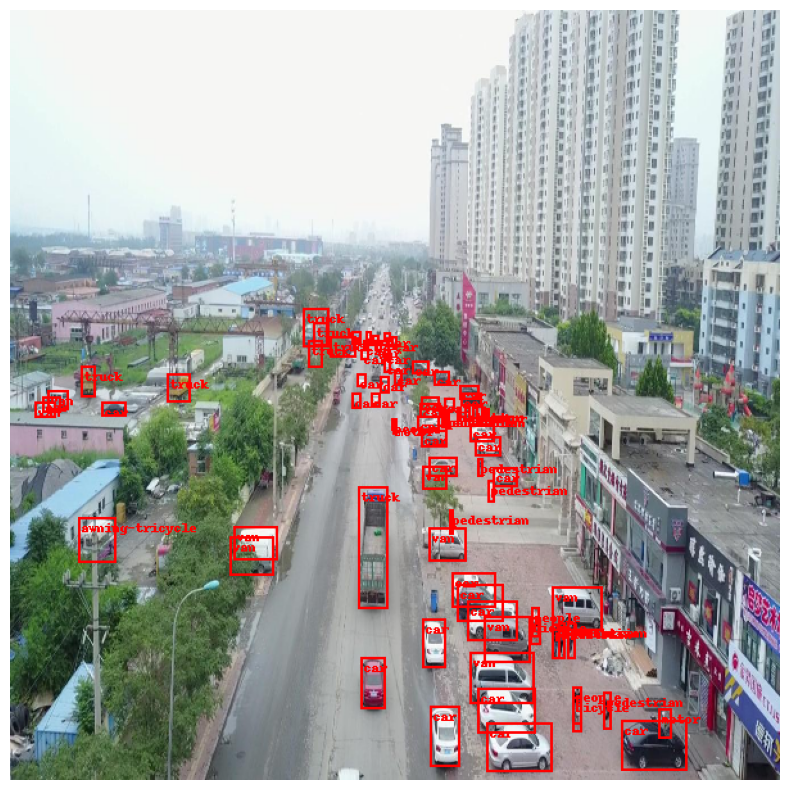

In [17]:
plot_random_image(train_dataset, class_names_dict)

In [18]:
# Load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [19]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [20]:
device = torch.device("cuda") # use GPU to train

In [21]:
model = model.to(device)

In [22]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [23]:
import sys

In [24]:
lst_loss = []

In [25]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    lst_loss.append(np.mean(all_losses))
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [26]:
num_epochs = 40

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 1618/1618 [03:44<00:00,  7.22it/s]


Epoch 0, lr: 0.010000, loss: 1.068193, loss_classifier: 0.401673, loss_box: 0.354630, loss_rpn_box: 0.199262, loss_object: 0.112628


100%|██████████| 1618/1618 [03:40<00:00,  7.34it/s]


Epoch 1, lr: 0.010000, loss: 0.964636, loss_classifier: 0.351938, loss_box: 0.343611, loss_rpn_box: 0.175508, loss_object: 0.093578


100%|██████████| 1618/1618 [03:40<00:00,  7.35it/s]


Epoch 2, lr: 0.010000, loss: 0.924822, loss_classifier: 0.334001, loss_box: 0.339369, loss_rpn_box: 0.165826, loss_object: 0.085626


100%|██████████| 1618/1618 [03:38<00:00,  7.39it/s]


Epoch 3, lr: 0.010000, loss: 0.895329, loss_classifier: 0.320934, loss_box: 0.335004, loss_rpn_box: 0.159017, loss_object: 0.080375


100%|██████████| 1618/1618 [03:38<00:00,  7.41it/s]


Epoch 4, lr: 0.010000, loss: 0.871792, loss_classifier: 0.309982, loss_box: 0.330497, loss_rpn_box: 0.154266, loss_object: 0.077046


100%|██████████| 1618/1618 [03:37<00:00,  7.42it/s]


Epoch 5, lr: 0.010000, loss: 0.854357, loss_classifier: 0.302850, loss_box: 0.327399, loss_rpn_box: 0.150479, loss_object: 0.073628


100%|██████████| 1618/1618 [03:38<00:00,  7.41it/s]


Epoch 6, lr: 0.010000, loss: 0.838067, loss_classifier: 0.295085, loss_box: 0.324855, loss_rpn_box: 0.146884, loss_object: 0.071243


100%|██████████| 1618/1618 [03:37<00:00,  7.44it/s]


Epoch 7, lr: 0.010000, loss: 0.824772, loss_classifier: 0.289028, loss_box: 0.322942, loss_rpn_box: 0.143855, loss_object: 0.068947


100%|██████████| 1618/1618 [03:37<00:00,  7.43it/s]


Epoch 8, lr: 0.010000, loss: 0.812880, loss_classifier: 0.283616, loss_box: 0.320509, loss_rpn_box: 0.141563, loss_object: 0.067192


100%|██████████| 1618/1618 [03:37<00:00,  7.44it/s]


Epoch 9, lr: 0.010000, loss: 0.800991, loss_classifier: 0.278018, loss_box: 0.318284, loss_rpn_box: 0.138987, loss_object: 0.065702


100%|██████████| 1618/1618 [03:36<00:00,  7.46it/s]


Epoch 10, lr: 0.010000, loss: 0.790493, loss_classifier: 0.273426, loss_box: 0.316848, loss_rpn_box: 0.137124, loss_object: 0.063095


100%|██████████| 1618/1618 [03:36<00:00,  7.48it/s]


Epoch 11, lr: 0.010000, loss: 0.781021, loss_classifier: 0.268486, loss_box: 0.315651, loss_rpn_box: 0.135228, loss_object: 0.061656


100%|██████████| 1618/1618 [03:36<00:00,  7.47it/s]


Epoch 12, lr: 0.010000, loss: 0.773799, loss_classifier: 0.265315, loss_box: 0.314688, loss_rpn_box: 0.133454, loss_object: 0.060341


100%|██████████| 1618/1618 [03:35<00:00,  7.51it/s]


Epoch 13, lr: 0.010000, loss: 0.765608, loss_classifier: 0.261654, loss_box: 0.313814, loss_rpn_box: 0.131825, loss_object: 0.058315


100%|██████████| 1618/1618 [03:35<00:00,  7.52it/s]


Epoch 14, lr: 0.010000, loss: 0.758124, loss_classifier: 0.257601, loss_box: 0.312277, loss_rpn_box: 0.130278, loss_object: 0.057967


100%|██████████| 1618/1618 [03:35<00:00,  7.52it/s]


Epoch 15, lr: 0.010000, loss: 0.749834, loss_classifier: 0.254025, loss_box: 0.310553, loss_rpn_box: 0.128883, loss_object: 0.056372


100%|██████████| 1618/1618 [03:34<00:00,  7.54it/s]


Epoch 16, lr: 0.010000, loss: 0.743322, loss_classifier: 0.250556, loss_box: 0.310033, loss_rpn_box: 0.127223, loss_object: 0.055510


100%|██████████| 1618/1618 [03:34<00:00,  7.54it/s]


Epoch 17, lr: 0.010000, loss: 0.737000, loss_classifier: 0.247462, loss_box: 0.308923, loss_rpn_box: 0.126244, loss_object: 0.054372


100%|██████████| 1618/1618 [03:34<00:00,  7.56it/s]


Epoch 18, lr: 0.010000, loss: 0.732931, loss_classifier: 0.245181, loss_box: 0.309073, loss_rpn_box: 0.124925, loss_object: 0.053751


100%|██████████| 1618/1618 [03:33<00:00,  7.57it/s]


Epoch 19, lr: 0.010000, loss: 0.727170, loss_classifier: 0.242646, loss_box: 0.307847, loss_rpn_box: 0.123815, loss_object: 0.052861


100%|██████████| 1618/1618 [03:32<00:00,  7.60it/s]


Epoch 20, lr: 0.010000, loss: 0.721653, loss_classifier: 0.241088, loss_box: 0.306694, loss_rpn_box: 0.122390, loss_object: 0.051482


100%|██████████| 1618/1618 [03:32<00:00,  7.61it/s]


Epoch 21, lr: 0.010000, loss: 0.719150, loss_classifier: 0.238958, loss_box: 0.308174, loss_rpn_box: 0.121641, loss_object: 0.050377


100%|██████████| 1618/1618 [03:32<00:00,  7.61it/s]


Epoch 22, lr: 0.010000, loss: 0.715880, loss_classifier: 0.237633, loss_box: 0.307220, loss_rpn_box: 0.120865, loss_object: 0.050162


100%|██████████| 1618/1618 [03:32<00:00,  7.61it/s]


Epoch 23, lr: 0.010000, loss: 0.709401, loss_classifier: 0.234333, loss_box: 0.305300, loss_rpn_box: 0.119719, loss_object: 0.050049


100%|██████████| 1618/1618 [03:31<00:00,  7.64it/s]


Epoch 24, lr: 0.010000, loss: 0.704968, loss_classifier: 0.232741, loss_box: 0.305150, loss_rpn_box: 0.118591, loss_object: 0.048487


100%|██████████| 1618/1618 [03:31<00:00,  7.64it/s]


Epoch 25, lr: 0.010000, loss: 0.699667, loss_classifier: 0.229627, loss_box: 0.304419, loss_rpn_box: 0.117564, loss_object: 0.048058


100%|██████████| 1618/1618 [03:31<00:00,  7.66it/s]


Epoch 29, lr: 0.010000, loss: 0.686677, loss_classifier: 0.223371, loss_box: 0.302874, loss_rpn_box: 0.114132, loss_object: 0.046300


100%|██████████| 1618/1618 [03:30<00:00,  7.67it/s]


Epoch 30, lr: 0.010000, loss: 0.682360, loss_classifier: 0.221448, loss_box: 0.302227, loss_rpn_box: 0.113383, loss_object: 0.045301


100%|██████████| 1618/1618 [03:30<00:00,  7.69it/s]


Epoch 31, lr: 0.010000, loss: 0.681740, loss_classifier: 0.221602, loss_box: 0.301878, loss_rpn_box: 0.113106, loss_object: 0.045153


100%|██████████| 1618/1618 [03:30<00:00,  7.69it/s]


Epoch 32, lr: 0.010000, loss: 0.677406, loss_classifier: 0.218896, loss_box: 0.301528, loss_rpn_box: 0.112008, loss_object: 0.044975


100%|██████████| 1618/1618 [03:30<00:00,  7.70it/s]


Epoch 33, lr: 0.010000, loss: 0.676102, loss_classifier: 0.218996, loss_box: 0.301384, loss_rpn_box: 0.111572, loss_object: 0.044150


100%|██████████| 1618/1618 [03:30<00:00,  7.70it/s]


Epoch 34, lr: 0.010000, loss: 0.671360, loss_classifier: 0.216091, loss_box: 0.300537, loss_rpn_box: 0.110733, loss_object: 0.043998


100%|██████████| 1618/1618 [03:29<00:00,  7.71it/s]


Epoch 35, lr: 0.010000, loss: 0.670301, loss_classifier: 0.215604, loss_box: 0.300849, loss_rpn_box: 0.110166, loss_object: 0.043682


100%|██████████| 1618/1618 [03:30<00:00,  7.69it/s]


Epoch 36, lr: 0.010000, loss: 0.667844, loss_classifier: 0.214619, loss_box: 0.300752, loss_rpn_box: 0.109457, loss_object: 0.043017


100%|██████████| 1618/1618 [03:30<00:00,  7.70it/s]


Epoch 37, lr: 0.010000, loss: 0.664963, loss_classifier: 0.213670, loss_box: 0.299552, loss_rpn_box: 0.108946, loss_object: 0.042795


100%|██████████| 1618/1618 [03:29<00:00,  7.71it/s]


Epoch 38, lr: 0.010000, loss: 0.663144, loss_classifier: 0.212431, loss_box: 0.299644, loss_rpn_box: 0.108578, loss_object: 0.042492


100%|██████████| 1618/1618 [03:29<00:00,  7.73it/s]

Epoch 39, lr: 0.010000, loss: 0.659727, loss_classifier: 0.210832, loss_box: 0.299217, loss_rpn_box: 0.107584, loss_object: 0.042093


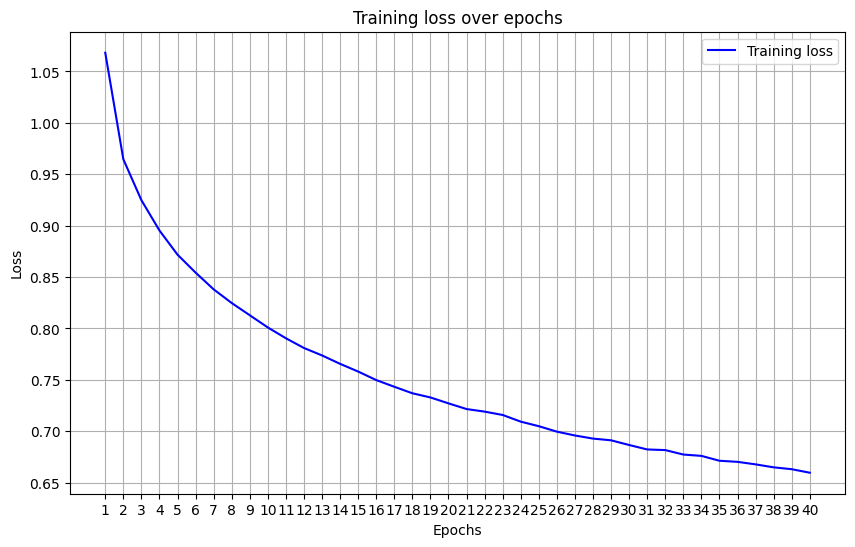

In [27]:
epochs = range(1, len(lst_loss) + 1)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(epochs, lst_loss, 'b', label='Training loss')
plt.title('Training loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(lst_loss) + 1, 1))  # Customize the x-axis ticks
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Save the trained model
torch.save(model.state_dict(), 'visdrone2019_faster_rcnn.pth')

In [29]:
model.eval()
torch.cuda.empty_cache()

In [30]:
classes = ['pedestrian', 'people', 'bicycle', 'car', 'van','truck', 'tricycle', 'awning-tricycle',
           'bus','motor']

In [31]:
# Load the saved state dictionary into the model
model.load_state_dict(torch.load('visdrone2019_faster_rcnn.pth'))

# Set the model to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

## Predict a random image

In [32]:
idx = random.randint(0, len(test_dataset) - 1)
img, gt = test_dataset[idx]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

**Prediction**

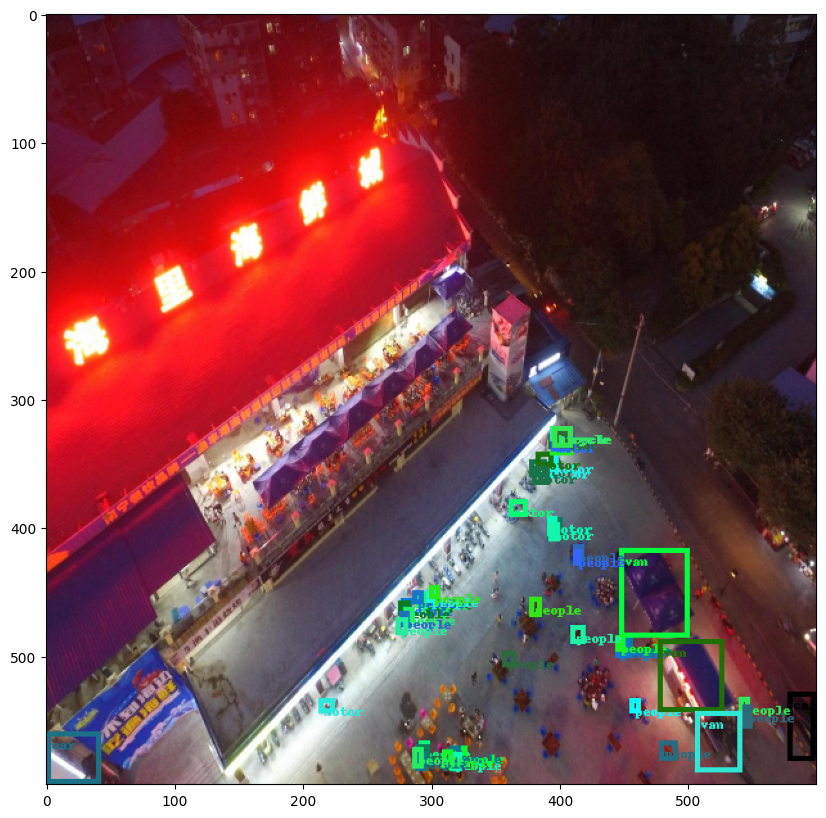

In [33]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.25],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.25].tolist()], width=4
).permute(1, 2, 0))

**Ground truth**

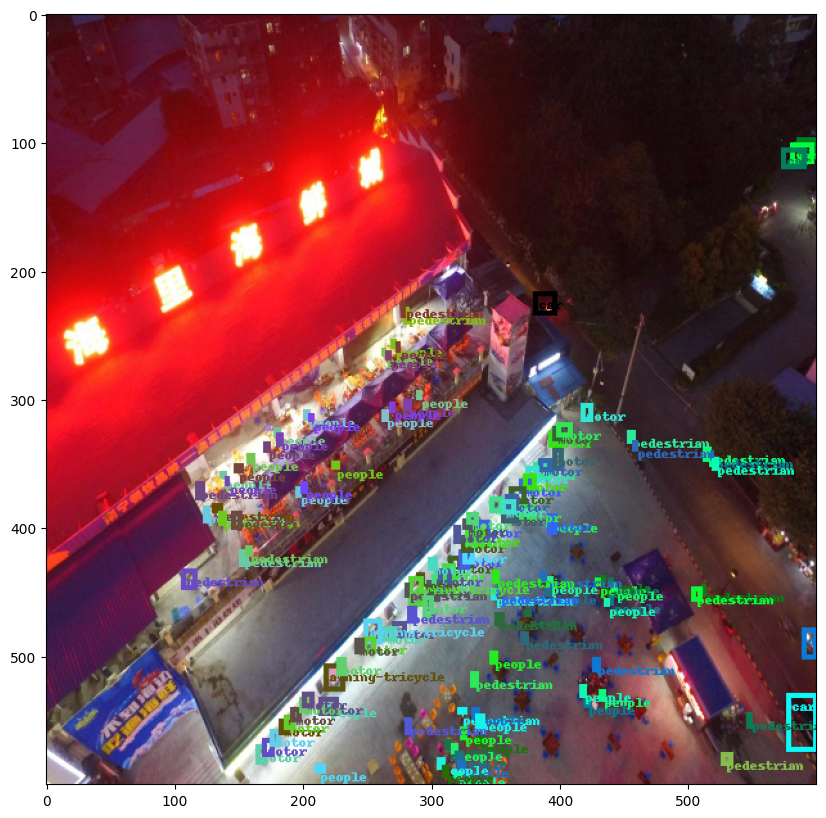

In [34]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    gt['boxes'], [classes[i] for i in gt['labels'].tolist()], width=4
).permute(1, 2, 0))

In [35]:
def create_df_mAP(test_dataset, model, class_names_dict):
    boxes_gt = []
    class_gt = []
    img_id_gt = []

    boxes_pred = []
    class_pred = []
    img_id_pred = []
    scores_pred = []
    for i in range(len(test_dataset)): # loop over each image in test set
        img_id = 'img_' + str(i)
        img, gt = test_dataset[i]
        img_int = torch.tensor(img*255, dtype=torch.uint8)
        with torch.no_grad():
            prediction = model([img.to(device)])
            pred = prediction[0]
            
        for class_id, class_name in class_names_dict.items():
            class_name_i = class_name
            predicted_boxes_idx = np.where(np.asarray(pred['labels'].tolist()) == class_id)[0]
            predicted_scores_idx = np.where(np.asarray(pred['scores'].tolist()) >= 0.25)[0]
            common_idx = list(set(predicted_boxes_idx) & set(predicted_scores_idx))
  
            predicted_boxes = np.asarray(pred['boxes'].tolist())[common_idx]
            predicted_labels = np.asarray(pred['labels'].tolist())[common_idx]
            predicted_scores = np.asarray(pred['scores'].tolist())[common_idx]
            
            if(len(predicted_boxes) != 0):
                for k in range(len(predicted_boxes)):
                    boxes_pred.append(np.asarray(predicted_boxes[k],dtype="int")) 
                    class_pred.append(class_names_dict.get(predicted_labels[k]))
                    scores_pred.append(predicted_scores[k])
                    img_id_pred.append(img_id)

            gt_idx = np.where(np.array(gt['labels'].tolist()) == class_id)
            gt_boxes = np.array(gt['boxes'].tolist())[gt_idx]
            gt_labels = np.array(gt['labels'].tolist())[gt_idx]
            
            if(len(gt_boxes) != 0):
                for j in range(len(gt_boxes)):
                    boxes_gt.append(np.asarray(gt_boxes[j],dtype="int")) 
                    class_gt.append(class_names_dict.get(gt_labels[j]))
                    img_id_gt.append(img_id)
    pred_df = pd.DataFrame({'box_pred': boxes_pred, 'confidence': scores_pred, 'class': class_pred, 'img_id': img_id_pred})
    gt_df = pd.DataFrame({'box_gt': boxes_gt, 'class': class_gt, 'img_id': img_id_gt})
    return gt_df,pred_df

In [36]:
gt_df,pred_df = create_df_mAP(test_dataset, model, class_names_dict)

In [37]:
gt_df

,box_gt,class,img_id
0,"[500, 124, 504, 141]",pedestrian,img_0
1,"[467, 108, 474, 123]",pedestrian,img_0
2,"[457, 124, 462, 138]",pedestrian,img_0
3,"[382, 77, 385, 85]",pedestrian,img_0
4,"[302, 363, 350, 414]",car,img_0
...,...,...,...
75097,"[153, 430, 161, 445]",bus,img_1609
75098,"[179, 426, 187, 441]",bus,img_1609
75099,"[196, 426, 204, 439]",bus,img_1609
75100,"[211, 421, 220, 436]",bus,img_1609


In [38]:
def convert_bbox_format(bbox):
    x_min, y_min, x_max, y_max = bbox
    return [(x_min, y_min), (x_max, y_max)]

In [39]:
# Apply the function to the 'box_gt' column
gt_df['box_gt'] = gt_df['box_gt'].apply(convert_bbox_format)

In [40]:
gt_df

,box_gt,class,img_id
0,"[(500, 124), (504, 141)]",pedestrian,img_0
1,"[(467, 108), (474, 123)]",pedestrian,img_0
2,"[(457, 124), (462, 138)]",pedestrian,img_0
3,"[(382, 77), (385, 85)]",pedestrian,img_0
4,"[(302, 363), (350, 414)]",car,img_0
...,...,...,...
75097,"[(153, 430), (161, 445)]",bus,img_1609
75098,"[(179, 426), (187, 441)]",bus,img_1609
75099,"[(196, 426), (204, 439)]",bus,img_1609
75100,"[(211, 421), (220, 436)]",bus,img_1609


In [41]:
pred_df

,box_pred,confidence,class,img_id
0,"[503, 126, 507, 137]",0.356143,people,img_0
1,"[501, 129, 506, 140]",0.479693,people,img_0
2,"[500, 126, 504, 137]",0.560137,people,img_0
3,"[498, 125, 502, 135]",0.366510,people,img_0
4,"[191, 427, 249, 466]",0.999256,car,img_0
...,...,...,...,...
64435,"[127, 427, 156, 448]",0.788426,truck,img_1609
64436,"[179, 424, 193, 439]",0.644029,truck,img_1609
64437,"[178, 424, 201, 445]",0.664821,truck,img_1609
64438,"[211, 423, 220, 435]",0.408525,truck,img_1609


In [42]:
# Apply the function to the 'box_gt' column
pred_df['box_pred'] = pred_df['box_pred'].apply(convert_bbox_format)

In [43]:
pred_df

,box_pred,confidence,class,img_id
0,"[(503, 126), (507, 137)]",0.356143,people,img_0
1,"[(501, 129), (506, 140)]",0.479693,people,img_0
2,"[(500, 126), (504, 137)]",0.560137,people,img_0
3,"[(498, 125), (502, 135)]",0.366510,people,img_0
4,"[(191, 427), (249, 466)]",0.999256,car,img_0
...,...,...,...,...
64435,"[(127, 427), (156, 448)]",0.788426,truck,img_1609
64436,"[(179, 424), (193, 439)]",0.644029,truck,img_1609
64437,"[(178, 424), (201, 445)]",0.664821,truck,img_1609
64438,"[(211, 423), (220, 435)]",0.408525,truck,img_1609


In [44]:
gt_df.to_csv('/kaggle/working/' + 'gt_test_df.csv', index=False)
pred_df.to_csv('/kaggle/working/' + 'pred_test_df.csv', index=False)

In [45]:
from shapely.geometry import Polygon
from shapely.geometry import Polygon, mapping

In [46]:
def calculate_IoU(box_A, box_B):
    top_left_A = box_A[0]
    bottom_right_A = box_A[1]
    top_right_A = (bottom_right_A[0], top_left_A[1])
    bottom_left_A = (top_left_A[0], bottom_right_A[1])
    
    top_left_B = box_B[0]
    bottom_right_B = box_B[1]
    top_right_B = (bottom_right_B[0], top_left_B[1])
    bottom_left_B = (top_left_B[0], bottom_right_B[1])
    
    A = Polygon([top_left_A, top_right_A, bottom_right_A, bottom_left_A]).buffer(0)
    B = Polygon([top_left_B, top_right_B, bottom_right_B, bottom_left_B])
    
    if(A.intersection(B)):
        intersection = A.intersection(B).area
        union = A.union(B).area
        iou = intersection/union
        return iou
    else:
        return 0

In [47]:
def IoU_per_class(sub_gt_df, sub_pred_df_sorted, class_name):
    IoU = []
    for i in range(sub_pred_df_sorted.shape[0]):
        box_pred_i = sub_pred_df_sorted.iloc[i]['box_pred']
        img_id = sub_pred_df_sorted.iloc[i]['img_id']
        
        boxes_gt_i_df = sub_gt_df[sub_gt_df['img_id'] == img_id]
        if(boxes_gt_i_df.shape[0] == 0):
            iou = 0.0
            IoU.append(iou)
        else:
            max_iou = -1
            idx_max = None
            for j in range(boxes_gt_i_df.shape[0]):
                iou = calculate_IoU(box_pred_i, boxes_gt_i_df.iloc[j]['box_gt'])
                if (iou > max_iou):
                    max_iou = iou
                    idx_max = boxes_gt_i_df.iloc[[j]].index.values[0]
            IoU.append(max_iou)
            if(max_iou > 0.0001):
                sub_gt_df.drop(index = [idx_max]) 
    sub_pred_df_sorted['IoU'] = IoU
    return sub_pred_df_sorted

In [48]:
IoU_threshold = 0.5
def check_IoU(df, col_name):
    df['IoU > IoU_threshold'] = df[col_name].apply(lambda x: x >= IoU_threshold)
    return df

In [49]:
def cumulative(df, IoU_bool, Acc_TP, Acc_FP):
    # base
    cum_TP = 0
    cum_FP = 0
    if (df[IoU_bool].iloc[0] == True):
        df.loc[0, Acc_TP] = cum_TP + 1
        cum_TP+=1
    else:
        df.loc[0, Acc_FP] = cum_FP + 1 
        cum_FP+=1
    # loop 
    for i in range(1, df.shape[0]):
        if (df[IoU_bool].iloc[i] == True):
            cum_TP+=1
            df.loc[i, Acc_TP] = cum_TP
            df.loc[i, Acc_FP] = cum_FP
        else:
            cum_FP+=1
            df.loc[i, Acc_TP] = cum_TP
            df.loc[i, Acc_FP] = cum_FP         
    return df

In [50]:
def get_the_rest(sorted_array, value):
    idx = None
    flag = False
    for i in range(len(sorted_array)):
        value_i = sorted_array[i]
        if(value_i >= value):
            idx = i
            flag = True
            break
    return flag, idx

In [51]:
def calculate_AP_n_points(precisions, recalls, step = 0.01):
    recall_interpolations = np.around(np.arange(0, 1+step, step, dtype=float), 2)
    precision_interpolations = []
    for i in range(len(recall_interpolations)):
        value = recall_interpolations[i]
        flag, idx = get_the_rest(recalls, value)

        if(flag):
            precisions_temp = precisions[idx:]
            max_precision = precisions_temp.max()
            precision_interpolations.append(max_precision)
        else:
            precision_interpolations.append(0)
    return precision_interpolations, recall_interpolations    

In [52]:
def riemann_sum(precisions, recalls, type_sum):
    cumulative = 0
    for i in range(len(recalls)-1):
        range_rc = recalls[i+1] - recalls[i]
        if(type_sum == 'right'):
            cumulative+=range_rc*precisions[i+1]
        if(type_sum == 'left'):
            cumulative+=range_rc*precisions[i]
        if(type_sum == 'mid'):
            cumulative+=range_rc*((precisions[i]+precisions[i+1])/2)
    return cumulative   

In [53]:
def calculate_AP_all_points(precisions, recalls):
    recall_interpolations = recalls
    precision_interpolations = []
    for i in range(len(recall_interpolations)):
        value = recall_interpolations[i]
        flag, idx = get_the_rest(recalls, value)
        if(flag):
            precisions_temp = precisions[idx:]
            max_precision = precisions_temp.max()
            precision_interpolations.append(max_precision)
        else:
            precision_interpolations.append(0)
    return precision_interpolations, recall_interpolations    

In [54]:
def AP_per_class(gt_df, pred_df, class_name):
    sub_gt_df = gt_df[gt_df['class'] == class_name].reset_index(drop = True)
    num_of_gt = len(sub_gt_df)
    
    sub_pred_df = pred_df[pred_df['class'] == class_name].reset_index(drop = True)
    if(sub_pred_df.shape[0] != 0):
        sub_pred_df_sorted = sub_pred_df.sort_values(by=['confidence'], ascending=False).reset_index(drop = True)

        sub_pred_df_sorted = IoU_per_class(sub_gt_df, sub_pred_df_sorted, class_name)
        sub_pred_df_sorted = check_IoU(sub_pred_df_sorted, 'IoU')

        sub_pred_df_sorted['Acc_TP'], sub_pred_df_sorted['Acc_FP'] = [0,0]
        sub_pred_df_sorted = cumulative(sub_pred_df_sorted, 'IoU > IoU_threshold', 'Acc_TP', 'Acc_FP')

        sub_pred_df_sorted['Precision'] = sub_pred_df_sorted.apply(lambda x: x['Acc_TP']/(x['Acc_TP'] + x['Acc_FP']), axis=1)
        sub_pred_df_sorted['Recall'] = sub_pred_df_sorted['Acc_TP'].apply(lambda x: x/num_of_gt)
        
        precisions = sub_pred_df_sorted['Precision'].values
        recalls = sub_pred_df_sorted['Recall'].values
        precision_interpolations, recall_interpolations = calculate_AP_n_points(precisions, recalls, step = 0.01)
        cum_sum = riemann_sum(precision_interpolations, recall_interpolations, type_sum = 'mid')
        return cum_sum
    else:
        return 0

In [55]:
gt_df[gt_df['img_id'] == 'img_0']['class'].unique()

array(['pedestrian', 'car', 'van', 'truck', 'motor'], dtype=object)

In [56]:
pred_df[pred_df['img_id'] == 'img_0']['class'].unique()

array(['people', 'car', 'van', 'truck', 'tricycle', 'motor'], dtype=object)

In [57]:
classes

['pedestrian',
 'people',
 'bicycle',
 'car',
 'van',
 'truck',
 'tricycle',
 'awning-tricycle',
 'bus',
 'motor']

In [58]:
AP_lst = []
for x in classes:
    AP_x = AP_per_class(gt_df, pred_df, x)
    AP_lst.append(AP_x)

In [59]:
AP_lst

[0,
 0.02065525969334709,
 0.011510766698669593,
 0.4731175454831615,
 0.1434016847981767,
 0.17724138697749478,
 0.053279006419295644,
 0.051407127991086654,
 0.3690167018245557,
 0.06264505109783597]

In [60]:
for i in range(len(classes)):
    print('Class: {} with AP = {}'.format(classes[i], AP_lst[i]))

Class: pedestrian with AP = 0
Class: people with AP = 0.02065525969334709
Class: bicycle with AP = 0.011510766698669593
Class: car with AP = 0.4731175454831615
Class: van with AP = 0.1434016847981767
Class: truck with AP = 0.17724138697749478
Class: tricycle with AP = 0.053279006419295644
Class: awning-tricycle with AP = 0.051407127991086654
Class: bus with AP = 0.3690167018245557
Class: motor with AP = 0.06264505109783597


In [61]:
mAP = np.mean(AP_lst)
mAP

0.13622745309836234